In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from models.linear_hp import hp_invert

# Import your MPC function with the w_penalty argument
from models.mpc_general import mpc_cvxpy

In [3]:
# # -------------------------------------------------------------------
# # 1) LOAD DATA
# # -------------------------------------------------------------------
# data_dir = os.path.join(os.getcwd(), 'data')
# total_df = pd.read_pickle(os.path.join(data_dir, 'total_df.pkl'))

# # -------------------------------------------------------------------
# # 2) DEFINE SIMULATION PARAMETERS
# # -------------------------------------------------------------------
# start_date = pd.to_datetime('2021-08-01 00:00:00')
# end_date = start_date + timedelta(days=31)

# dt = 900  # 15 minutes in seconds
# horizon = int(12 * (3600 / dt))  # 12-hour horizon
# tes_capacity = 27.0 * 2.0

# # Define a range of penalty weights for Pareto analysis (adjust as needed)
# w_values = np.arange(0, 0.5, 0.05)

# # This list will store summary metrics for each penalty weight
# pareto_results = []

# # -------------------------------------------------------------------
# # 3) SIMULATION LOOP OVER PENALTY WEIGHTS
# # -------------------------------------------------------------------
# for w in w_values:
#     print(f"Running simulation for w_penalty = {w}")
#     date = start_date
#     soc_init = 0.0
#     total_cost = 0.0
#     hp_state_sequence = []  # Records HP on/off states (1: on, 0: off)
#     simulation_results = pd.DataFrame()  # Optional: record detailed results per weight

#     while date < end_date:
#         # Run the MPC controller for the current time step with the given penalty weight
#         res, soc_final, energy_cost_val, penalty_cost_val, overall_cost_val = mpc_cvxpy(
#             horizon=horizon,
#             dt=dt,
#             datetime=date,
#             df=total_df,
#             soc_init=soc_init,
#             Q_dot_pcm=10.0,
#             w_penalty=w
#         )

#         # Retrieve first-step decision outputs from the MPC horizon
#         u_pcm = res['u_pcm'].iloc[0]
#         load = res['load'].iloc[0]
#         e_price = res['e_price'].iloc[0]
#         T_cond = total_df.loc[date, 'outdoor_temp']

#         # Calculate the required cooling load over dt (in kWh)
#         Q_cool = load + u_pcm * (dt / 3600.0)
#         # Use the HP inversion model to compute energy consumption (e_hp)
#         e_hp = hp_invert(Q_cool, T_cond)[2]
#         cost = e_price * e_hp
#         total_cost += cost

#         # Determine the HP state: assume HP is on if the cooling load is above a tiny threshold
#         hp_state = 1 if Q_cool > 1e-3 else 0
#         hp_state_sequence.append(hp_state)

#         # Update state-of-charge (SOC) based on PCM energy input over dt
#         soc_init = soc_final

#         # Optionally, record detailed results for each timestep
#         res_real = {
#             'datetime': date,
#             'u_pcm': u_pcm,
#             'Q_cool': Q_cool,
#             'soc': soc_init,
#             'outdoor_temp': T_cond,
#             'load': load,
#             'e_price': e_price,
#             'e_hp': e_hp,
#             'cost': cost
#         }
#         simulation_results = pd.concat([simulation_results, pd.DataFrame([res_real])], ignore_index=True)

#         print(f"Current date: {date}   with weight: {w}")
#         date += timedelta(seconds=dt)

#     # Count HP on/off toggles from the recorded hp_state_sequence
#     toggle_count = sum(abs(hp_state_sequence[i+1] - hp_state_sequence[i])
#                        for i in range(len(hp_state_sequence) - 1))

#     # Save summary metrics for this penalty weight
#     pareto_results.append({
#         'w_penalty': w,
#         'total_cost': total_cost,
#         'hp_toggle_frequency': toggle_count,
#         'simulation_results': simulation_results  # detailed results (optional)
#     })

# # -------------------------------------------------------------------
# # 4) SAVE PARETO SUMMARY RESULTS
# # -------------------------------------------------------------------
# pareto_summary = pd.DataFrame([
#     {'w_penalty': r['w_penalty'], 'total_cost': r['total_cost'], 'hp_toggle_frequency': r['hp_toggle_frequency']}
#     for r in pareto_results
# ])

# pareto_summary.to_pickle('./results/pareto_summary.pkl')

# # Optionally, save detailed simulation results for each penalty weight
# for r in pareto_results:
#     w = r['w_penalty']
#     sim_res = r['simulation_results']
#     sim_res.to_pickle(f'./results/simulation_results_w{w:.3f}.pkl')

# print("Pareto analysis simulation completed.")

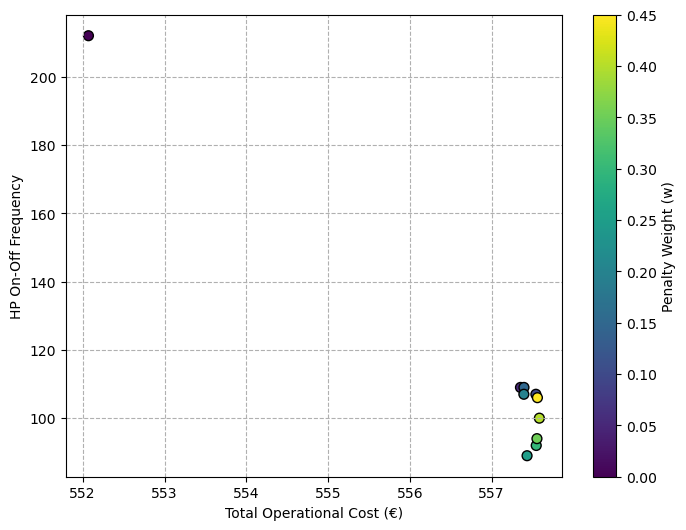

In [5]:
pareto_summary = pd.read_pickle('./results/pareto_summary.pkl')

operational_costs = pareto_summary['total_cost']
hp_toggle_frequencies = pareto_summary['hp_toggle_frequency']

# -------------------------------------------------------------------
# 1) PLOT THE PARETO RESULTS
# -------------------------------------------------------------------
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    operational_costs, 
    hp_toggle_frequencies, 
    c=w_values, 
    cmap='viridis', 
    edgecolor='k', 
    s=50
)
plt.xlabel("Total Operational Cost (€)")
plt.ylabel("HP On-Off Frequency")
plt.colorbar(sc, label='Penalty Weight (w)')
plt.grid(True, linestyle='--')

# # -------------------------------------------------------------------
# # 2) LOAD YOUR BASELINE SCENARIO AND ADD IT TO THE PLOT
# # -------------------------------------------------------------------
# baseline_path = os.path.join('results', 'baseline_15T.pkl')  
# baseline = pd.read_pickle(baseline_path)

# date_range = pd.date_range(start='2021-08-01 00:00:00', end='2021-08-31 23:59:59', freq='15min')

# baseline_df = baseline.loc[date_range, :]

# baseline_df['e_hp'] = baseline_df['load'] * baseline_df['e_hp'] / (baseline_df['load'] + 1e-3)
# baseline_df['rpm'] = baseline_df['load'] * baseline_df['rpm'] / (baseline_df['load'] + 1e-3)

# # Compute total operational cost for the baseline
# baseline_df['cost'] = baseline_df['e_hp'] * baseline_df['e_price'] * 0.001
# baseline_total_cost = baseline_df['cost'].sum()


# hp_state = [1 if baseline_df['load'].values[i] > 1e-3 else 0 for i in range(len(baseline_df))]
# baseline_toggle_count = sum(abs(hp_state[i+1] - hp_state[i])
#                        for i in range(len(hp_state) - 1))

# # Plot the baseline point in red with an 'X' marker
# plt.scatter(
#     baseline_total_cost, 
#     baseline_toggle_count, 
#     marker='X', 
#     s=120, 
#     c='red', 
#     label='Baseline'
# )

# -------------------------------------------------------------------
# 3) SHOW THE FINAL PLOT WITH LEGEND
# -------------------------------------------------------------------
# plt.legend()
plt.show()
